In [1]:
#!pip install syft==0.2.9

In [1]:
# import required libraries and packages

import os
import sys

import random

import numpy as np

import torch  
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus import PrivacyEngine

from torch import optim
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F

from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

In [2]:
print(sys.version)
print(torch.__version__)

3.10.5 (main, Jun 30 2022, 11:24:25) [GCC 8.3.0]
1.13.1+cu116


In [3]:
ROOT_DIR = os.path.abspath('../')
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

print(ROOT_DIR)

DATA_DIR = os.path.join(ROOT_DIR, 'data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'models/PATE/')

/usr4/ugrad/cjxu/Documents/MA751


In [5]:
# normalize data

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV),
])

In [6]:
# download data 
train_dataset = CIFAR10(
    root=os.path.join(DATA_DIR, 'trainset'), train=True, download=True, transform=transform)

test_dataset = CIFAR10(
    root=os.path.join(DATA_DIR, 'testset'), train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print('num training data: {0}'.format(len(train_dataset)))
print('num test data: {0}'.format(len(test_dataset)))

num training data: 50000
num test data: 10000


In [8]:
def init_teachers(train_dataset, batch_size=64, num_teachers=10):
    """
    Takes as input the training dataset and divides it into n disjoint subsets
    which will serve as training data for our teacher models. Outputs a dataloader 
    for each disjoint subset
    """
    teachers_loader = []
    
    data_per_teacher = len(train_dataset)//num_teachers
    
    # create n disjoint subsets
    for i in range(num_teachers):
         # check if i is equal to the last teacher
        if i == num_teachers - 1:
            idx=list(range(i * data_per_teacher, len(train_dataset)))
        else:
            idx=list(range(i*data_per_teacher, (i + 1)*data_per_teacher))
        
        teacher_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        teachers_loader.append(teacher_loader)
        
    return teachers_loader

In [9]:
teacher_loaders = init_teachers(train_dataset, num_teachers=10)
# sanity check
len(teacher_loaders)

10

In [10]:
def init_student(dataset, batch_size = 64, split=0.7):
    """
    Takes as input the test dataset and splits it into public and private subsets. 
    
    """
    split_idx = int(len(dataset) * split)
    student_train = Subset(dataset, list(range(0, split_idx)))
    student_test = Subset(dataset, list(range(split_idx, len(dataset))))
    
    student_train_loader = torch.utils.data.DataLoader(student_train, batch_size=batch_size)
    student_test_loader =  torch.utils.data.DataLoader(student_test, batch_size=batch_size)
    
    return student_train, student_test, student_train_loader, student_test_loader

In [11]:
student_train, student_test, student_train_loader, student_test_loader = init_student(test_dataset)
print(len(student_train_loader))
print(len(student_test_loader))

110
47


In [12]:
def predict(teacher_models, dataloader):
    pred_labels = []
    for model in teacher_models:
        model.to(device)
        pred_label = []
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                output = model(images)
                ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)        
            pred_label.append(top_class.squeeze().tolist())
        pred_label = sum(pred_label, [])
        pred_labels.append(pred_label)
    return pred_labels

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2), #32 x 16 x 16
            #nn.Dropout(0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2), # 64 x 8 x 8
            #nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2), # 128 x 4 x 4
            #nn.Dropout(0.4), 
    

            nn.Flatten(),
            nn.Linear(128*4*4, 128),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(128, 10))
            
    def forward(self, x):
        x = F.log_softmax(x, dim=1)
        return self.network(x)

model = Net()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def train(model, criterion, optimizer, train_loader, epochs=10): 
    model.to(device)
    # train_losses, train_accs = [], []
    os.chdir(MODEL_DIR) 

    for e in range(epochs):
        running_loss = 0
        acc = 0
            
        for images, labels in train_loader:    
            images, labels = images.to(device), labels.to(device)
                
            optimizer.zero_grad()        
                
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()        
            running_loss += loss.item() 
                
            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)        
            equals = top_class == labels.view(*top_class.shape)
            acc += torch.mean(equals.type(torch.FloatTensor))
    
                
        print('epoch: {}/{}'.format(e+1, epochs),
              'training loss: {:.3f} '.format(running_loss / len(train_loader)),
              'training acc: {:.3f} '.format(acc / len(train_loader)),
                '')         

    return model

In [ ]:
teacher_models = []

for teacher in teacher_loaders:
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    teacher_model = train(model, criterion, optimizer, teacher)
    teacher_models.append(teacher_model)

epoch: 1/10 training loss: 1.730  training acc: 0.369  
epoch: 2/10 training loss: 1.401  training acc: 0.502  
epoch: 3/10 training loss: 1.196  training acc: 0.582  
epoch: 4/10 training loss: 1.060  training acc: 0.631  
epoch: 5/10 training loss: 0.970  training acc: 0.661  
epoch: 6/10 training loss: 0.885  training acc: 0.689  
epoch: 7/10 training loss: 0.814  training acc: 0.712  
epoch: 8/10 training loss: 0.752  training acc: 0.734  
epoch: 9/10 training loss: 0.688  training acc: 0.758  
epoch: 10/10 training loss: 0.638  training acc: 0.772  
epoch: 1/10 training loss: 1.744  training acc: 0.366  
epoch: 2/10 training loss: 1.439  training acc: 0.489  
epoch: 3/10 training loss: 1.252  training acc: 0.562  
epoch: 4/10 training loss: 1.113  training acc: 0.611  
epoch: 5/10 training loss: 1.011  training acc: 0.646  
epoch: 6/10 training loss: 0.921  training acc: 0.677  
epoch: 7/10 training loss: 0.841  training acc: 0.704  
epoch: 8/10 training loss: 0.781  training acc:

In [17]:
# preds = predict(teacher_models, student_train_loader)
# preds = np.array([np.array(p) for p in preds]).transpose(1, 0)

preds = np.loadtxt(os.path.join(MODEL_DIR, 'preds.txt'), dtype=int)

In [18]:
def add_gaussian_noise(preds, epsilon, delta):
    noisy_labels = []
    
    for pred in preds:
        label_counts = np.bincount(pred, minlength=preds.shape[1])
        
        c = np.sqrt(2*np.log(1.25/delta))
        sigma = c / epsilon
        
        for i in range(len(label_counts)):
            label_counts[i] += np.random.normal(0, sigma, 1)
        
        new_label = np.argmax(label_counts)
        noisy_labels.append(new_label)
    
    return np.array(noisy_labels)

In [19]:
EPSILON = 10
DELTA = 1e-5
noisy_preds = add_gaussian_noise(preds, epsilon=EPSILON, delta=DELTA)
len(noisy_preds)

7000

In [ ]:
# from syft.frameworks.torch.differential_privacy import pate
# data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=teacher_preds, indices=diff_priv_labels, noise_eps=0.2, delta=1e-5)
# print("Data Independent Epsilon:", data_ind_eps)
# print("Data Dependent Epsilon:", data_dep_eps)

In [21]:
test_dataset.targets[:7000] = noisy_preds

student_train = Subset(test_dataset, list(range(7000)))
student_trainloader = torch.utils.data.DataLoader(student_train, batch_size=64, num_workers=0)

model_2 = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
model_2.to(device)
epochs = 100

train_losses, train_accs = [], []
for e in range(epochs): 
    train_loss = 0   
    train_acc = 0
    for images, labels in student_trainloader:          
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()   
        output = model_2(images)        
        loss = criterion(output, labels)        
        loss.backward()       
        optimizer.step()        
        train_loss += loss.item()
        
        pred = torch.exp(output)
        top_p, top_class = pred.topk(1, dim=1)        
        equals = top_class == labels.view(*top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(train_loss / len(student_trainloader))
    train_accs.append(train_acc.item() / len(student_trainloader))
    
    print('epoch: {}/{}'.format(e+1, epochs),
          'training loss: {:.3f} '.format(train_loss / len(student_trainloader)),
          'training acc: {:.3f} '.format(train_acc / len(student_trainloader)),
        ) 

epoch: 1/100 training loss: 2.055  training acc: 0.229 
epoch: 2/100 training loss: 1.731  training acc: 0.364 
epoch: 3/100 training loss: 1.546  training acc: 0.434 
epoch: 4/100 training loss: 1.391  training acc: 0.485 
epoch: 5/100 training loss: 1.263  training acc: 0.531 
epoch: 6/100 training loss: 1.139  training acc: 0.585 
epoch: 7/100 training loss: 1.043  training acc: 0.621 
epoch: 8/100 training loss: 0.940  training acc: 0.658 
epoch: 9/100 training loss: 0.862  training acc: 0.682 
epoch: 10/100 training loss: 0.743  training acc: 0.730 
epoch: 11/100 training loss: 0.682  training acc: 0.752 
epoch: 12/100 training loss: 0.675  training acc: 0.760 
epoch: 13/100 training loss: 0.587  training acc: 0.796 
epoch: 14/100 training loss: 0.582  training acc: 0.792 
epoch: 15/100 training loss: 0.507  training acc: 0.820 
epoch: 16/100 training loss: 0.448  training acc: 0.841 
epoch: 17/100 training loss: 0.401  training acc: 0.857 
epoch: 18/100 training loss: 0.397  trai

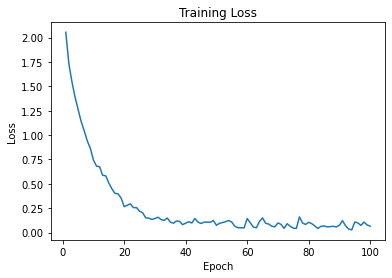

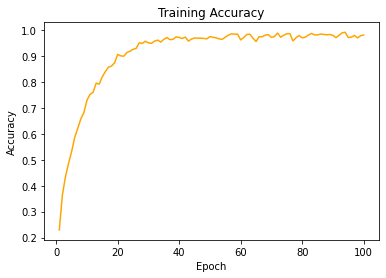

In [22]:
# summarize history for accuracy
import matplotlib.pyplot as plt
epochs = range(1, 100+1)
plt.plot(epochs, train_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(epochs, train_accs, color='orange')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [23]:
test_loss = 0
test_acc = 0

model_2.to(device)
model_2.eval()

with torch.no_grad(): 
    for images, labels in student_test_loader:              
        images, labels = images.to(device), labels.to(device)
        output = model_2(images)
        test_loss += criterion(output, labels).item()  
               
        # Calculate test accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)        
        equals = top_class == labels.view(*top_class.shape)
        test_acc += torch.mean(equals.type(torch.FloatTensor))
        
        
        
print("test loss: {:.5f}   ".format(test_loss/len(student_test_loader)),
      "test accuracy: {:.5f}".format(test_acc/len(student_test_loader)))

test loss: 9.13088    test accuracy: 0.48034
